Running on Device: cuda
Files already downloaded and verified


/home/knallap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/knallap/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40] Gen Loss: 1.8383, Disc Loss: 0.3630, FID: 139.4044
Epoch [2/40] Gen Loss: 1.6002, Disc Loss: 0.4877, FID: 139.0355
Epoch [3/40] Gen Loss: 1.3269, Disc Loss: 0.6358, FID: 136.0083
Epoch [4/40] Gen Loss: 1.1410, Disc Loss: 0.5861, FID: 136.4604
Epoch [5/40] Gen Loss: 1.2326, Disc Loss: 0.6192, FID: 138.9083
Epoch [6/40] Gen Loss: 1.1363, Disc Loss: 0.6248, FID: 137.1871
Epoch [7/40] Gen Loss: 1.0832, Disc Loss: 0.6851, FID: 133.9361
Epoch [8/40] Gen Loss: 1.3704, Disc Loss: 0.6112, FID: 139.2445
Epoch [9/40] Gen Loss: 0.9771, Disc Loss: 0.6351, FID: 137.5055
Epoch [10/40] Gen Loss: 0.9474, Disc Loss: 0.5535, FID: 137.2037
Epoch [11/40] Gen Loss: 1.0044, Disc Loss: 0.6380, FID: 137.9433
Epoch [12/40] Gen Loss: 0.9321, Disc Loss: 0.6407, FID: 137.5947
Epoch [13/40] Gen Loss: 0.8511, Disc Loss: 0.6611, FID: 136.6020
Epoch [14/40] Gen Loss: 0.9493, Disc Loss: 0.6819, FID: 136.5187
Epoch [15/40] Gen Loss: 1.0065, Disc Loss: 0.6155, FID: 138.6119
Epoch [16/40] Gen Loss: 1.2722, Di

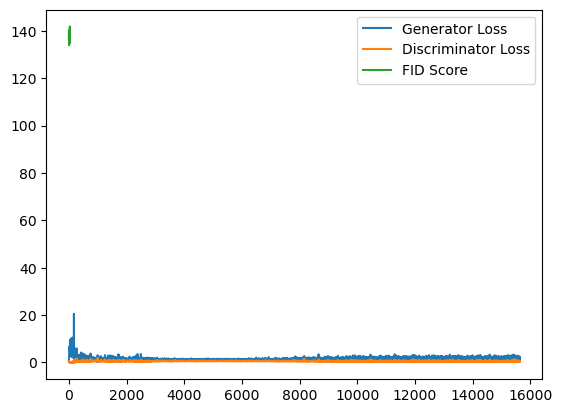

In [2]:
import torch
import torch.nn as nn_module
import torch.optim as optimizers
import torchvision
import torchvision.datasets as vision_datasets
import torch.nn.functional as F
import torchvision.transforms as data_transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as image_utils
from scipy import linalg
import os
import time

# Set random seed and device
torch.manual_seed(1)
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on Device:', compute_device)

# Hyperparameters
LEARNING_RATE = 2e-4
BATCH_COUNT = 128
IMG_RESIZE = 64
IMG_CHANNELS = 3
LATENT_VECTOR_SIZE = 100
EPOCH_COUNT = 40
DISCRIMINATOR_FEATURES = 64
GENERATOR_FEATURES = 64
ADAM_BETA = 0.5

# Data Loading and Preprocessing
transform_pipeline = data_transforms.Compose([
    data_transforms.Resize(IMG_RESIZE),
    data_transforms.ToTensor(),
    data_transforms.Normalize([0.5] * 3, [0.5] * 3),
])

cifar_dataset = vision_datasets.CIFAR10(root="./CIFAR10data", download=True, transform=transform_pipeline)
data_loader = DataLoader(cifar_dataset, batch_size=BATCH_COUNT, shuffle=True, num_workers=2)

# Results Directory
os.makedirs('Results', exist_ok=True)
os.makedirs('Models', exist_ok=True)


# Discriminator Model
class ImageCritic(nn_module.Module):
    def __init__(self, input_channels, feature_dims):
        super(ImageCritic, self).__init__()
        self.architecture = nn_module.Sequential(
            nn_module.Conv2d(input_channels, feature_dims, kernel_size=4, stride=2, padding=1),
            nn_module.LeakyReLU(0.2),
            self.critic_block(feature_dims, feature_dims * 2, 4, 2, 1),
            self.critic_block(feature_dims * 2, feature_dims * 4, 4, 2, 1),
            self.critic_block(feature_dims * 4, feature_dims * 8, 4, 2, 1),
            nn_module.Conv2d(feature_dims * 8, 1, kernel_size=4, stride=2, padding=0),
            nn_module.Sigmoid(),
        )

    def critic_block(self, in_features, out_features, kernel_size, stride, padding):
        return nn_module.Sequential(
            nn_module.Conv2d(in_features, out_features, kernel_size, stride, padding, bias=False),
            nn_module.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.architecture(x)


# Generator Model
class ImageGenerator(nn_module.Module):
    def __init__(self, latent_dim, output_channels, feature_dims):
        super(ImageGenerator, self).__init__()
        self.generator_architecture = nn_module.Sequential(
            self.generator_block(latent_dim, feature_dims * 16, 4, 1, 0),
            self.generator_block(feature_dims * 16, feature_dims * 8, 4, 2, 1),
            self.generator_block(feature_dims * 8, feature_dims * 4, 4, 2, 1),
            self.generator_block(feature_dims * 4, feature_dims * 2, 4, 2, 1),
            nn_module.ConvTranspose2d(feature_dims * 2, output_channels, kernel_size=4, stride=2, padding=1),
            nn_module.Tanh(),
        )

    def generator_block(self, in_features, out_features, kernel_size, stride, padding):
        return nn_module.Sequential(
            nn_module.ConvTranspose2d(in_features, out_features, kernel_size, stride, padding, bias=False),
            nn_module.BatchNorm2d(out_features, momentum=0.9),
            nn_module.ReLU(),
        )

    def forward(self, x):
        return self.generator_architecture(x)

# Function to save and visualize Real vs Fake Images
def save_comparison_images(real_images, fake_images, epoch, results_dir='Results/Comparison_Images'):
    os.makedirs(results_dir, exist_ok=True)
    
    # Create image grids
    real_grid = image_utils.make_grid(real_images[:16], normalize=True, padding=2)
    fake_grid = image_utils.make_grid(fake_images[:16], normalize=True, padding=2)

    # Plot the grids
    plt.figure(figsize=(12, 6))
    
    # Plot Real Images
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(real_grid.cpu().numpy(), (1, 2, 0)))

    # Plot Fake Images
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_grid.cpu().numpy(), (1, 2, 0)))

    # Save the comparison plot
    plt.savefig(f"{results_dir}/comparison_epoch_{epoch:03d}.png", bbox_inches='tight', dpi=150)
    plt.close()

# Initialize Model Weights
def initialize_model_weights(model):
    for layer in model.modules():
        if isinstance(layer, (nn_module.Conv2d, nn_module.ConvTranspose2d, nn_module.BatchNorm2d)):
            nn_module.init.normal_(layer.weight.data, 0.0, 0.02)


# Instantiate Models and Optimizers
generator = ImageGenerator(LATENT_VECTOR_SIZE, IMG_CHANNELS, GENERATOR_FEATURES).to(compute_device)
discriminator = ImageCritic(IMG_CHANNELS, DISCRIMINATOR_FEATURES).to(compute_device)
initialize_model_weights(generator)
initialize_model_weights(discriminator)

gen_optimizer = optimizers.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA, 0.999))
disc_optimizer = optimizers.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA, 0.999))

loss_function = nn_module.BCELoss()

# Fixed Noise for Visualization
fixed_latent_noise = torch.randn(32, LATENT_VECTOR_SIZE, 1, 1).to(compute_device)

# Training Setup
gen_losses, disc_losses, fid_scores, image_grid_list = [], [], [], []
start_time = time.time()

# FID Pretrained InceptionV3 Model
class InceptionV3Features(nn_module.Module):
    """Pretrained InceptionV3 for extracting features for FID calculation."""

    def __init__(self, output_blocks=[3]):
        super(InceptionV3Features, self).__init__()
        inception = models.inception_v3(pretrained=True)
        self.blocks = nn_module.ModuleList([
            nn_module.Sequential(inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3,
                                 nn_module.MaxPool2d(kernel_size=3, stride=2)),
            nn_module.Sequential(inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3, nn_module.MaxPool2d(kernel_size=3, stride=2)),
            nn_module.Sequential(inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d,
                                 inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d, inception.Mixed_6e),
            nn_module.Sequential(inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c, nn_module.AdaptiveAvgPool2d(output_size=(1, 1))),
        ])
        self.output_blocks = output_blocks

    def forward(self, x):
        outputs = []
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
        return outputs[-1]


# Load Pretrained InceptionV3
fid_model = InceptionV3Features().to(compute_device)

# FID Utility Functions
def calculate_statistics(images, model):
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    features = model(images).view(images.size(0), -1).detach().cpu().numpy()
    mean = np.mean(features, axis=0)
    covariance = np.cov(features, rowvar=False)
    return mean, covariance


def calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake):
    diff = mu_real - mu_fake
    cov_mean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * cov_mean)


# Training Loop
for epoch in range(EPOCH_COUNT):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(compute_device)
        batch_size = real_images.size(0)

        # Train Discriminator
        latent_noise = torch.randn(batch_size, LATENT_VECTOR_SIZE, 1, 1).to(compute_device)
        fake_images = generator(latent_noise)

        real_scores = discriminator(real_images).view(-1)
        fake_scores = discriminator(fake_images.detach()).view(-1)

        disc_real_loss = loss_function(real_scores, torch.ones_like(real_scores))
        disc_fake_loss = loss_function(fake_scores, torch.zeros_like(fake_scores))
        total_disc_loss = (disc_real_loss + disc_fake_loss) / 2

        disc_optimizer.zero_grad()
        total_disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        fake_scores = discriminator(fake_images).view(-1)
        gen_loss = loss_function(fake_scores, torch.ones_like(fake_scores))

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_losses.append(gen_loss.item())
        disc_losses.append(total_disc_loss.item())

    # FID Calculation
    mu_real, sigma_real = calculate_statistics(real_images, fid_model)
    mu_fake, sigma_fake = calculate_statistics(fake_images, fid_model)
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    fid_scores.append(fid_score)

    print(f"Epoch [{epoch + 1}/{EPOCH_COUNT}] Gen Loss: {gen_loss.item():.4f}, Disc Loss: {total_disc_loss.item():.4f}, FID: {fid_score:.4f}")
    
    # Save Generated Images
    with torch.no_grad():
        fake_images = generator(fixed_latent_noise).detach().cpu()
    image_grid = image_utils.make_grid(fake_images, padding=2, normalize=True)
    image_grid_list.append(image_grid)
    # Save Real vs Fake Comparison Images
    save_comparison_images(real_images=real_images.detach(), fake_images=fake_images.detach(), epoch=(epoch+1))

# Plot Results
plt.figure()
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.plot(fid_scores, label="FID Score")
plt.legend()
plt.show()


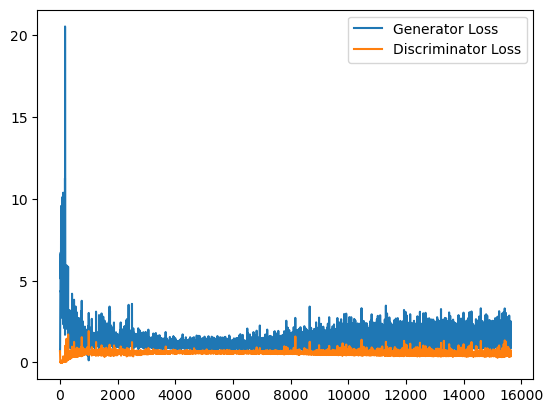

In [4]:
# Plot Results
plt.figure()
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.legend()
plt.show()

In [3]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/DC_FID', fid_scores) 